In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import joblib # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.model_selection import GridSearchCV, train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.ensemble import ExtraTreesClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.utils.class_weight import compute_class_weight # type: ignore
from sklearn.neural_network import MLPClassifier # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.inspection import permutation_importance # type: ignore
from sklearn.ensemble import StackingClassifier # type: ignore
from sklearn.ensemble import IsolationForest # type: ignore
from xgboost import XGBClassifier # type: ignore

In [2]:
# load the data
x_train = pd.read_csv('x_train_openSmile_gmaps_cluster.csv')
y_train = pd.read_csv('y_train_openSmile_gmaps_cluster.csv')
x_test = pd.read_csv('x_test_openSmile_gmaps_cluster.csv')
y_test = pd.read_csv('y_test_openSmile_gmaps_cluster.csv')

# convert to 1 vs rest
# y_train = y_train['emotion'].apply(lambda x: 1 if x == 'positive' else 0)
# y_test = y_test['emotion'].apply(lambda x: 1 if x == 'positive' else 0)

c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan 

              precision    recall  f1-score   support

    negative       0.62      0.85      0.72       433
     neutral       0.57      0.50      0.53       161
    positive       0.65      0.17      0.27       190

    accuracy                           0.61       784
   macro avg       0.61      0.51      0.51       784
weighted avg       0.62      0.61      0.57       784



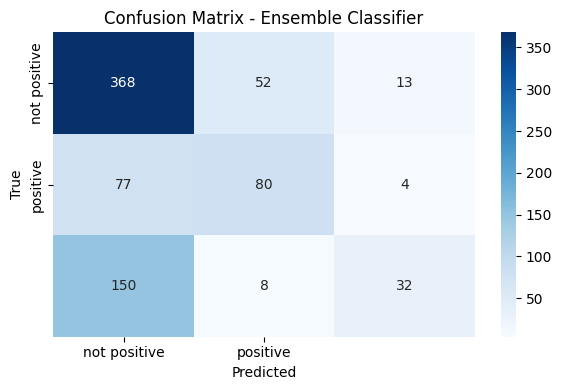

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define individual classifiers with pipelines
pipeline_lr = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline_svc = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('classifier', SVC(probability=True, random_state=42))
])

pipeline_rf = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grids for each classifier
param_grid_lr = {
    'feature_selection__k': [10, 15, 20],
    'classifier__C': [0.1, 1, 10]
}

param_grid_svc = {
    'feature_selection__k': [10, 15, 20],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

param_grid_rf = {
    'feature_selection__k': [10, 15, 20],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20]
}

# Perform grid search for each classifier
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)

grid_search_lr.fit(x_train, y_train)
grid_search_svc.fit(x_train, y_train)
grid_search_rf.fit(x_train, y_train)

# Get the best estimators
best_lr = grid_search_lr.best_estimator_
best_svc = grid_search_svc.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Create a voting classifier with the best models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svc', best_svc),
        ('rf', best_rf)
    ],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(x_train, y_train)

# Evaluate the ensemble model
y_pred = voting_clf.predict(x_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Ensemble Classifier")
plt.tight_layout()
plt.show()


Feature ranking:
1. feature 5 (0.036922)
2. feature 20 (0.027006)
3. feature 4 (0.025608)
4. feature 3 (0.022317)
5. feature 1 (0.020771)
6. feature 23 (0.020196)
7. feature 55 (0.019952)
8. feature 12 (0.018832)
9. feature 11 (0.018596)
10. feature 30 (0.018340)
11. feature 28 (0.018032)
12. feature 2 (0.017667)
13. feature 48 (0.017585)
14. feature 13 (0.017483)
15. feature 36 (0.017434)
16. feature 43 (0.017261)
17. feature 0 (0.017245)
18. feature 52 (0.017143)
19. feature 38 (0.016811)
20. feature 24 (0.016477)
21. feature 46 (0.016428)
22. feature 59 (0.016355)
23. feature 7 (0.016110)
24. feature 10 (0.016099)
25. feature 47 (0.016072)
26. feature 22 (0.016034)
27. feature 44 (0.015701)
28. feature 40 (0.015539)
29. feature 26 (0.015504)
30. feature 53 (0.015468)
31. feature 32 (0.015436)
32. feature 14 (0.015415)
33. feature 39 (0.015332)
34. feature 15 (0.015253)
35. feature 50 (0.015064)
36. feature 42 (0.014898)
37. feature 61 (0.014824)
38. feature 54 (0.014809)
39. feature

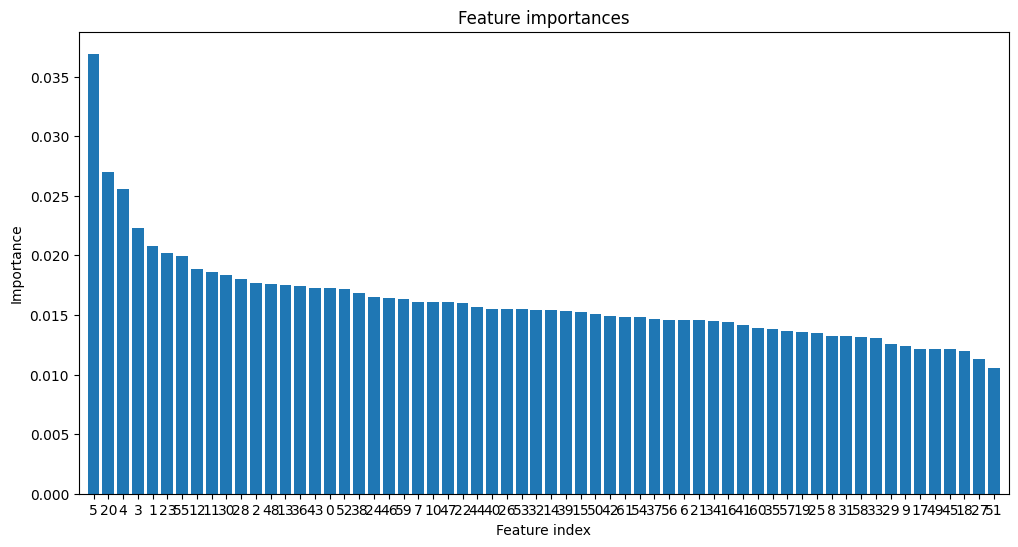

In [3]:
# dimension reduction based on feature importance
# using ExtraTreesClassifier to get feature importance
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train.values.ravel())
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.savefig('feature_importance.png')
plt.show()

In [4]:
# select top 10 features
x_train = x_train.iloc[:, indices[:26]]
x_test = x_test.iloc[:, indices[:26]]

In [5]:
print(y_train.value_counts())

emotion
0    1205
1     385
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       0.83      0.93      0.88       594
           1       0.65      0.41      0.50       190

    accuracy                           0.80       784
   macro avg       0.74      0.67      0.69       784
weighted avg       0.79      0.80      0.79       784



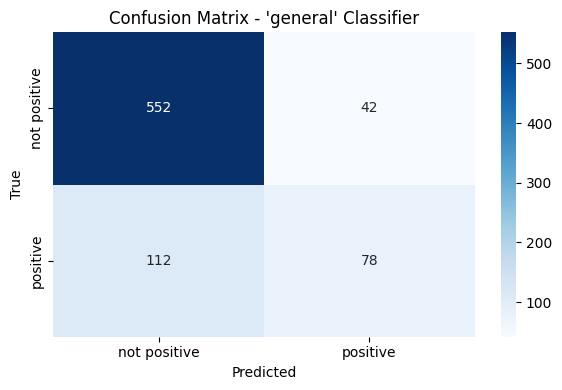

In [6]:
# train xgb model
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

# evaluate model
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       594
           1       0.55      0.74      0.63       190

    accuracy                           0.79       784
   macro avg       0.73      0.77      0.74       784
weighted avg       0.82      0.79      0.80       784



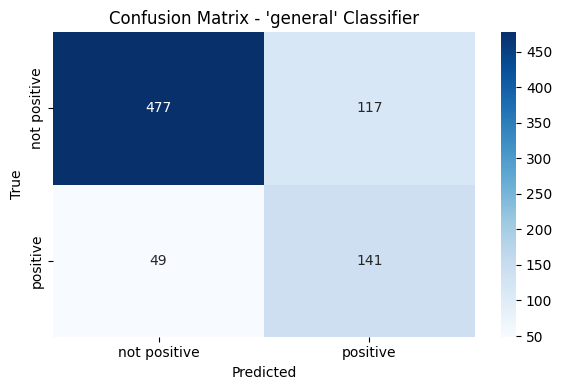

In [7]:
# svc model
svc = SVC(probability=True, class_weight="balanced", random_state=42, kernel='rbf')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
y_pred_proba = svc.predict_proba(x_test)[:, 1]

# evaluate model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()

c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039

              precision    recall  f1-score   support

           0       0.82      0.93      0.88       594
           1       0.65      0.37      0.47       190

    accuracy                           0.80       784
   macro avg       0.73      0.65      0.67       784
weighted avg       0.78      0.80      0.78       784



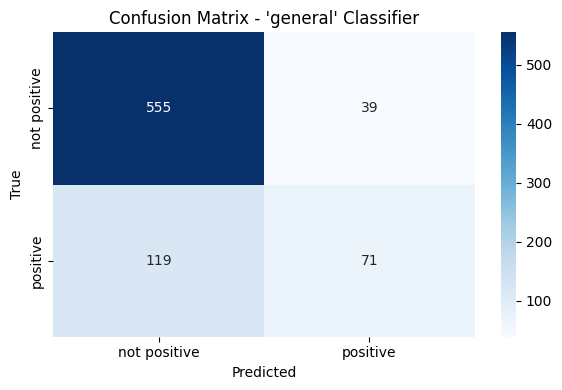

In [8]:
# train knn model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_pred_proba = knn.predict_proba(x_test)[:, 1]

# evaluate model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       594
           1       0.58      0.58      0.58       190

    accuracy                           0.80       784
   macro avg       0.73      0.73      0.73       784
weighted avg       0.80      0.80      0.80       784



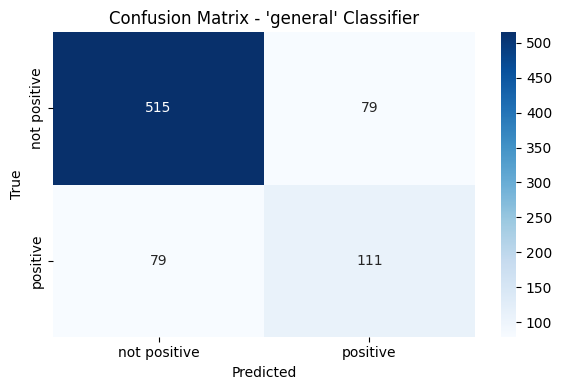

In [11]:
# train mlp grid search model
mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, n_iter_no_change=10)
param_grid = {
    'hidden_layer_sizes': [(8,), (16,), (32,), (32, 16), (16, 8), (32, 16, 8)],
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(x_train, y_train)
best_mlp = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
y_pred = best_mlp.predict(x_test)
y_pred_proba = best_mlp.predict_proba(x_test)[:, 1]

# evaluate model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1205
           1       0.77      0.77      0.77       385

    accuracy                           0.89      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.89      0.89      0.89      1590



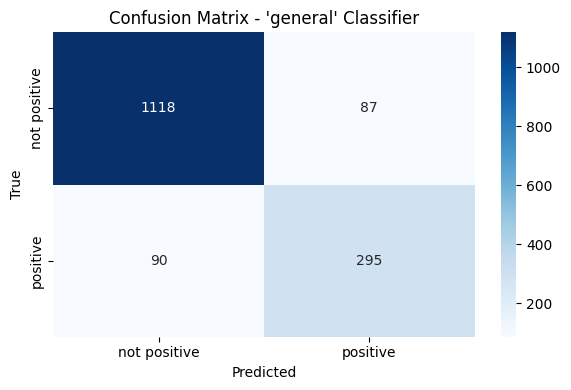

In [12]:
# test for overfitting
y_train_pred = best_mlp.predict(x_train)
y_train_pred_proba = best_mlp.predict_proba(x_train)[:, 1]
print(classification_report(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=['not positive', 'positive'],
    yticklabels=['not positive', 'positive']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'general' Classifier")
plt.tight_layout()
plt.show()

Cross-validation scores:
Accuracy:  0.7880503144654089
F1 Score:  0.373218793116055
ROC AUC:  0.6118284205421135
Precision:  0.6364161125071941
Recall:  0.2701298701298701


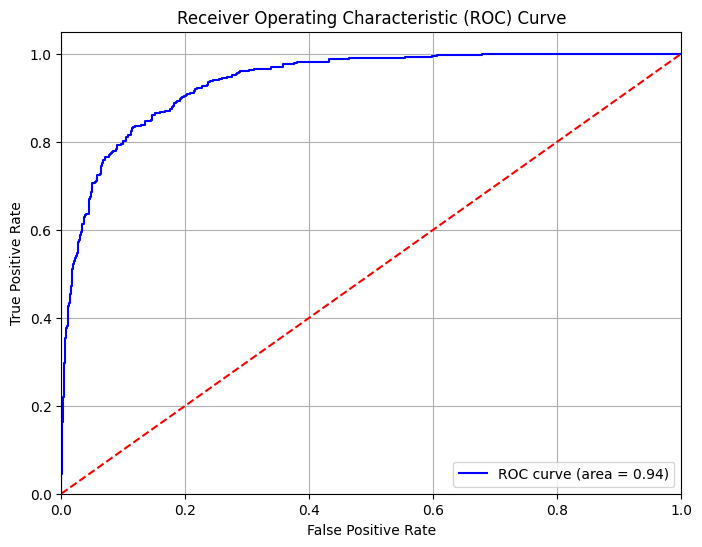

In [ ]:
# kfold cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score



# Define the model
model = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, n_iter_no_change=10)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation
scores = cross_validate(model, x_train, y_train, cv=cv, scoring=scoring)
# Print the scores
print("Cross-validation scores:")
print("Accuracy: ", scores['test_accuracy'].mean())
print("F1 Score: ", scores['test_f1'].mean())
print("ROC AUC: ", scores['test_roc_auc'].mean())
print("Precision: ", scores['test_precision'].mean())
print("Recall: ", scores['test_recall'].mean())

# Plot ROC curve
y_train_pred_proba = best_mlp.predict_proba(x_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
